In [4]:

# Import things
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import os
import glob
from scipy import io


In [5]:

# Data location: 

d_loc='/Users/heather/ICECAPS-ACE/Data/Drone_flights/'

# Get drone profile dates using dates from Kml files:

os.chdir(d_loc)
all_kml = glob.glob('*.kml')
all_dates = np.asarray([(dt.datetime.strptime(f.split()[1]+f.split()[2]+f.split()[3],'%m_%d_%Y%I_%M_%S%p')) for f in all_kml])

# Get opc profile filenames from M200 kml datetimes.

drone_fnames = []
for i in range(0,len(all_dates)):
    date = all_dates[i]
    drone_fname = glob.glob('SummitGreenland_ICECAPS-ACE_Drone_OPCN3_N3_%s*.csv'%(dt.datetime.strftime(date,'%Y%m%d%H')))
    if len(drone_fname)==0:
        drone_fname = glob.glob('SummitGreenland_ICECAPS-ACE_Drone_OPCN3_N3_%s*.csv'%(dt.datetime.strftime(date-dt.timedelta(hours=1),'%Y%m%d%H')))
        if len(drone_fname)==0:
            print('No drone profile found for %s'%date)
            continue
            
    drone_fnames.append(drone_fname)


No drone profile found for 2019-06-23 11:45:08
No drone profile found for 2019-06-22 15:31:26
No drone profile found for 2019-06-23 17:20:42
No drone profile found for 2019-06-24 09:15:19
No drone profile found for 2019-06-23 21:45:05
No drone profile found for 2019-06-23 11:00:13
No drone profile found for 2019-06-23 21:15:42


In [6]:

# Function to read Alphasense OPC-N3 raw data.
# Input:  dfile - Full path to raw Alphasense OPC N3 data file. 
# Ouput: opc - dataframe of aerosol distribution, counts in /cm3, and other parameters measured by OPC (e.g. T, P, flow rate ect)

def get_opc(dfile):
    opc = pd.read_csv(dfile, skiprows=4,sep=',',error_bad_lines=False) 
    opc['Dates'] = pd.to_datetime(opc['time'],format='%Y-%m-%d %H:%M:%S')
    opc = opc.sort_values('Dates')
    opc = opc.set_index(opc['Dates'])
    opc.index = pd.DatetimeIndex(opc.index)
    del opc['time'], opc['Dates']

    # Convert flow rate from L/min to cm3/s
    # 1 L/min = 16.66667 cm3/s
    opc.FlowRate = opc.FlowRate/100 * 16.66667
    opc[opc.columns[0:24]] = opc[opc.columns[0:24]].apply(pd.to_numeric, errors='coerce')

    # Convert counts/interval to total counts/s
    opc.period = opc.period/100.0 # period in s
    opc[opc.columns[0:24]] = opc[opc.columns[0:24]].divide(opc.period, axis=0)
    
    # Convert total counts/second to counts/cm3
    opc[opc.columns[0:24]] = opc[opc.columns[0:24]].divide(opc.FlowRate, axis=0)

    return opc


# Split profiles 1 - 4
# This function splits the OPC data from from the drone flight
# into seperate profiles based on pressure change.
# Works by finding pressure inflection points lasting > 20 s. 
# Input: df - Drone OPC dataframe as output by get_opc.
# Output: list_of_dfs - List of seperate dataframes split up based 
#                       on pressure inflections (drone vertical direction change)

def split_profiles(df):
    df['P_diff']=df['P'].diff(periods=20)
    df['P_dd']=df['P_diff'].diff(periods=20).abs()
    inflections = df[df['P_dd']<0.3].index
    ilist=[]
    for i in range(1,len(inflections)):
        if inflections[i]-inflections[i-1] > dt.timedelta(seconds=20):
            ilist.append(inflections[i])

    df['RowN'] = np.arange(len(df))
    l = list(df['RowN'].loc[ilist])
    l_mod = [0] + l + [max(df['RowN'])]
    list_of_dfs = [df.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)]
    return list_of_dfs

# Find start and end times
# This function finds the start and end times of each vertical drone profile based on pressure change.
# Input: List of dataframes as output from split_profiles
# Output: Start time and end time of each profile

def get_start_end(list_of_dfs):
    start = list_of_dfs[0]
    c=1
    while max(start.P)-min(start.P)<5:
        start = list_of_dfs[c]
        c=c+1
    
    start_time = start.index[0]

    end = list_of_dfs[-1]
    c=len(list_of_dfs)-1
    while max(end.P)-min(end.P)<5:
        end = list_of_dfs[c]
        c=c-1
    
    end_time = end.index[-1]
    return start_time,end_time

# Find MSF OPC data
# This function extracts the min, max and mean total aerosol concentration from 
# the stationary MSF OPC (on the MSF roof) throughout the duration of the drone profile.
# Input:  MSF_dloc   - MSF data location, filepath
#         start_time - The drone profile start time, from 'get_start_end'
#         end_time   - The drone profile end time, from 'get_start_end'
# Output: max, min and mean total aerosol concentration during drone flight from MSF OPC. (counts/cm3)

def get_MSF(MSF_dloc, start_time, end_time):
    dfile = 'Summit_MSF_ICECAPSACE_OPCN3_N1_%s.csv'%dt.datetime.strftime(start_time,'%Y-%m-%d')
    try:
        MSF_df = get_opc(MSF_dloc+dfile)
        MSF_df['OPC_conc'] = MSF_df[MSF_df.columns[0:24]].sum(axis=1) # Total aerosol concentration
        MSF_concs = MSF_df['OPC_conc'].between_time(str(start_time.time()),str(end_time.time()))
        MSF_concs.dropna(inplace=True)
        max_msf = max(MSF_concs)
        min_msf = min(MSF_concs)
        mean_msf = MSF_concs.mean()
    except IOError:
        print('Cant find MSF OPC file for %s'%start_time)
        return
    return max_msf,min_msf,mean_msf


# Plot profiles & Save

def plot_profile(list_of_dfs,min_msf,mean_msf,max_msf,start_time,save=False):
    fig = plt.figure(figsize=(5,7))
    ax = fig.add_subplot(111)
    for i in range(0,len(list_of_dfs)):
        d=list_of_dfs[i]
        d['OPC_conc'] = d[d.columns[0:24]].sum(axis=1) # Total aerosol concentration
        if max(d.P)-min(d.P)>5:
            ax.semilogx(d.OPC_conc,d.P,label=str(d.index[0].time()),alpha=0.8)
            maxP= max(d.P)
            minP= min(d.P)
        
    ax.scatter([min_msf,mean_msf,max_msf],[maxP-0.4,maxP-0.4,maxP-0.4],marker='X',c='m',label='MSF OPC during flight\n(min,mean,max)')
    ax.grid(True)
    ax.set_ylim(maxP,minP)
    ax.set_xlim(0.001,10)
    ax.set_ylabel('Pressure (hPa)')
    ax.set_title('Drone profile: \n%s'%str(start_time))
    ax.set_xlabel('Total aerosol concentration (cc)')
    ax.legend(loc='best',fontsize=9)
    fig.tight_layout()

    if save:
        fig.savefig(save + 'Drone_profile_%s.png'%str(start_time))
        

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['SummitGreenland_ICECAPS-ACE_Drone_OPCN3_N3_20190623083659.csv']: profile parse failed.


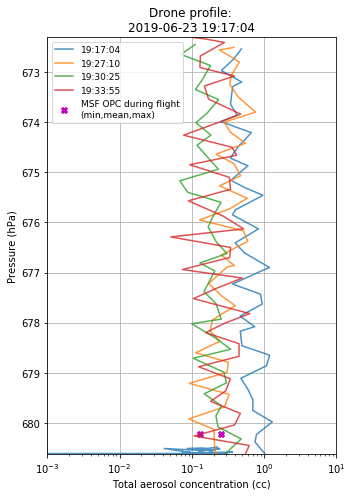

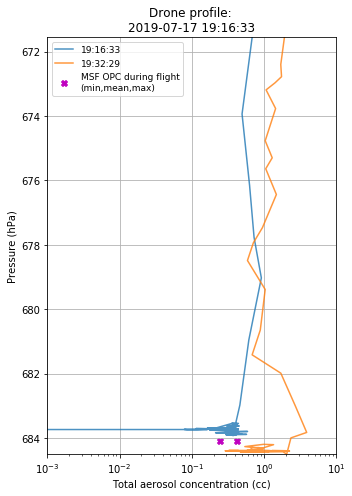

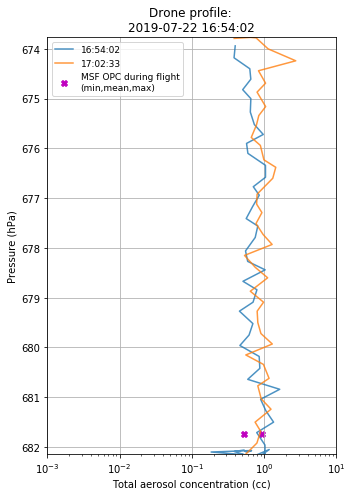

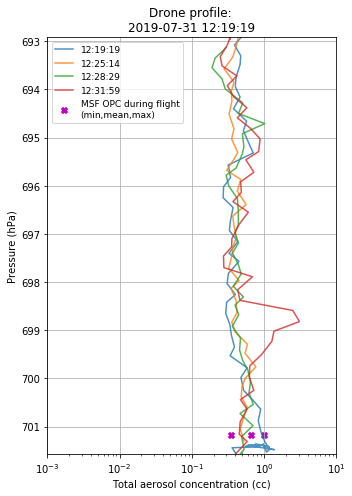

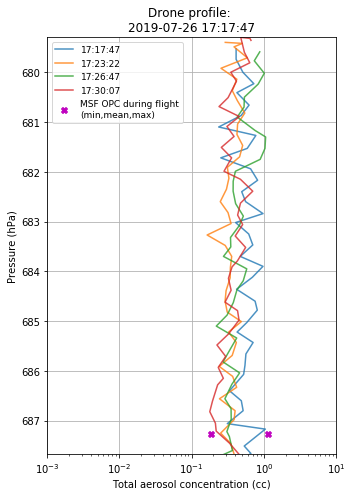

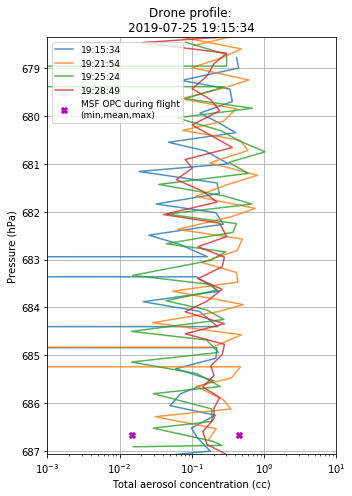

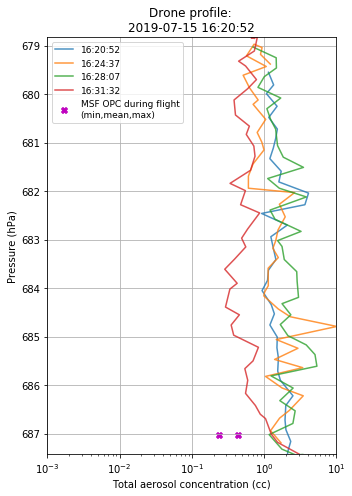

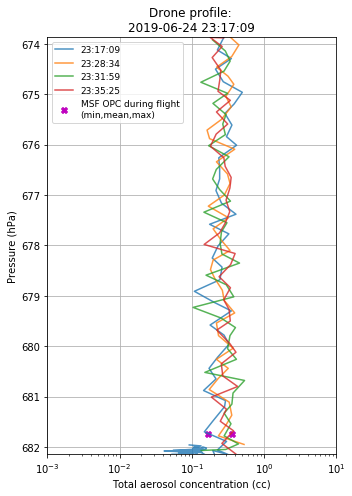

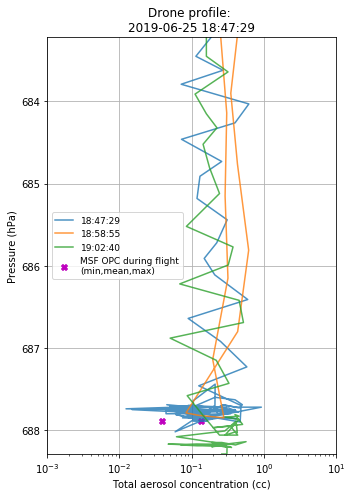

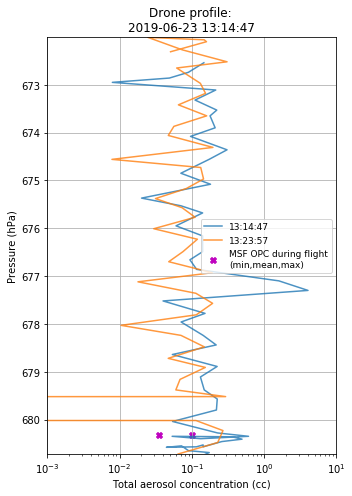

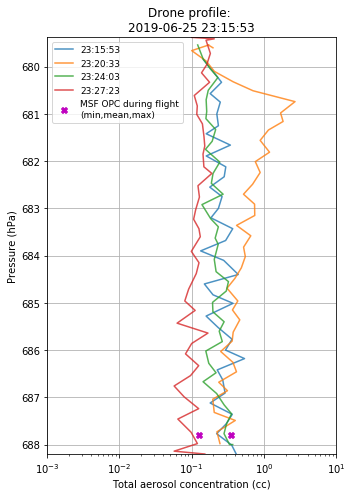

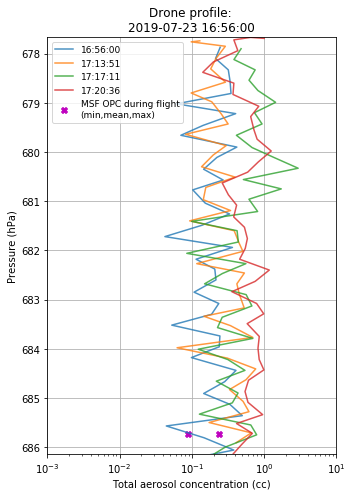

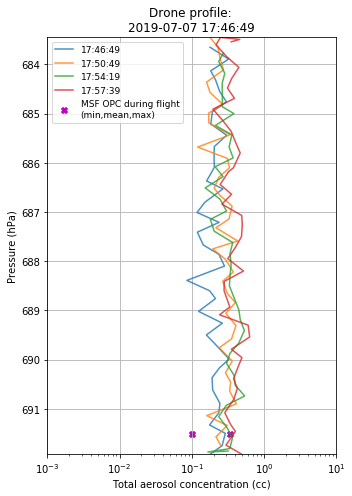

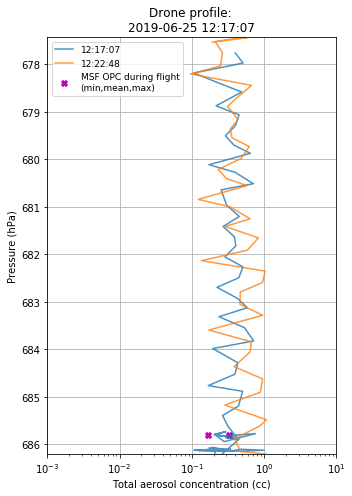

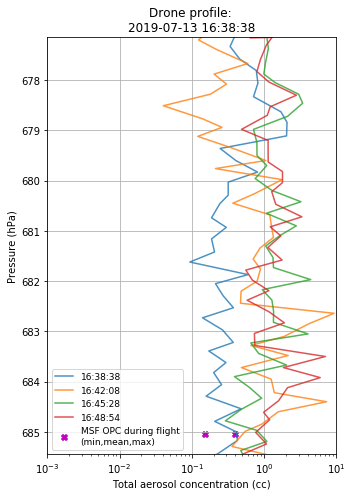

In [7]:

# Execute script for all drone profiles.

for fname in drone_fnames:
    df = get_opc(d_loc+fname[0])
    list_of_dfs = split_profiles(df)
    try:
        start_time,end_time = get_start_end(list_of_dfs)
        max_msf,min_msf,mean_msf = get_MSF(d_loc+'MSF_OPC/',start_time,end_time)
        plot_profile(list_of_dfs,min_msf,mean_msf,max_msf,start_time,save=d_loc+'Plots/')
    except:
        print('%s: profile parse failed.'%fname)
        pass
    